# Systematic uncertainties - background fit example

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Printout settings
np.set_printoptions(precision=3, linewidth=100, suppress=True)

# More advanced: prevent zeros from being stripped from the end of floats:
np.set_printoptions(formatter={'float_kind': '{: 0.3f}'.format})

### (1) Definition of background model

Consider controlled parameter range is [0,1]

In [3]:
# True background distribution

def mybg(x):
    
    bg = 10.0 - 2* x + x*x
    
    return bg

### (2) Definition of fit model

In [4]:
# Basic functions:  1, x, x^2, x^3 ...

def myfun(x,ifun):

    return np.power(x,ifun)

# Full model

def mymodel(x,par):

    val = np.zeros(x.size)
    
    for ip in range(par.size):
        val+=par[ip]*myfun(x,ip)
        
    return val

### (3) Generate pseudo data to fit

In [5]:
# Considered values of x

xvec = np.linspace(0.05,0.95,10)

# Measurement precision
# Assume background is measured with precision ten time better than in the actual experiment

#  svec = np.linspace(2.,4.,xvec.size)  # used for the actual experiment

svec = np.linspace(0.2,0.4,xvec.size)

s2vec = svec*svec

# Pseudo-data

yvec = np.random.normal(mybg(xvec),svec)


### (4)  Linear fit

In [15]:
# Number of model functions to consider 

Nfun = 3

A = np.zeros((Nfun,Nfun))

B = np.zeros(Nfun)

for l in range(Nfun):
    fl = myfun(xvec,l)
    B[l] = np.sum(fl*yvec/s2vec)
    for k in range(Nfun):
        fk = myfun(xvec,k)
        A[l,k] = np.sum(fl*fk/s2vec)


In [16]:
# Inverse of matrix

Cov = np.linalg.inv(A)

# Solution to the problem

par = Cov @ B

# Parameter uncertainties

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = np.array(Cov)

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = mymodel(xvec,par) 

# Chi^2 printout

chi2 = np.sum((yvec-fvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))

# print("\n  x       y        sigma_y ")
# for ix in range(xvec.size):
#      print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],svec[ix]))



 Fit results:

     par         sigma_p

    10.174  +/-  0.214 
    -2.915  +/-  1.185 
     1.560  +/-  1.265 

 Correlation matrix

[ 1.000 -0.842  0.719]
[-0.842  1.000 -0.962]
[ 0.719 -0.962  1.000]

 chi^2 =     4.175   chi^2/Ndf =  0.59645 


### (5) Draw background data and fit

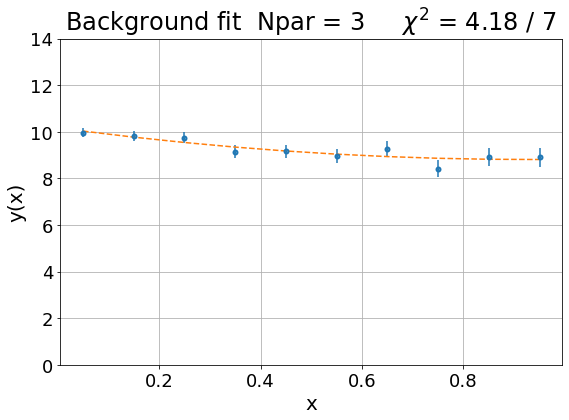

In [17]:
plt.figure(figsize=(9, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

plt.plot(xvec,fvec,'--')

plt.title('Background fit  Npar = '+str(Nfun)+'     $\chi^{2}$ = '+str(int(100*chi2+0.5)/100.)+' / '+str(xvec.size-Nfun),size=24)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0.,14.])
plt.grid(which='major', axis='both')

fname = '10_bg_fit_ev_'+str(Nfun)+'.png'
plt.savefig(fname)

### (6) Expected background covariance matrix

In [18]:
# Expected bacground values

muvec = mymodel(xvec,par) 

# Matrix of derivatives   $\partial \mu_i / \partial p_j$

Der = np.zeros((xvec.size,Nfun))

for ip in range(Nfun):
    Der[:,ip] = np.power(xvec,ip)

# Error propagation -> expectation covariance matrix

muCov = Der @ Cov @ np.transpose(Der)

# Background erros

muErr = np.sqrt(np.diagonal(muCov))

# Printout

print("\n Fitted background:\n\n     x        mu_bg      sigma_bg\n")

for ix in range(xvec.size):
    print("  %8.3f %8.3f  +/- %6.3f " % (xvec[ix],muvec[ix],muErr[ix]))

# Calculate correlation matrix

muCorr = np.array(muCov)

print("\n Correlation matrix\n")

for ix in range(xvec.size):
    for jx in range(xvec.size):
        muCorr[ix,jx]=muCorr[ix,jx]/muErr[ix]/muErr[jx]
        
    print(muCorr[ix,:])




 Fitted background:

     x        mu_bg      sigma_bg

     0.050   10.032  +/-  0.169 
     0.150    9.771  +/-  0.114 
     0.250    9.542  +/-  0.110 
     0.350    9.344  +/-  0.127 
     0.450    9.178  +/-  0.138 
     0.550    9.042  +/-  0.139 
     0.650    8.938  +/-  0.136 
     0.750    8.864  +/-  0.149 
     0.850    8.822  +/-  0.201 
     0.950    8.812  +/-  0.294 

 Correlation matrix

[ 1.000  0.847  0.360 -0.021 -0.217 -0.306 -0.293 -0.149  0.051  0.197]
[ 0.847  1.000  0.800  0.506  0.309  0.172  0.054 -0.044 -0.090 -0.092]
[ 0.360  0.800  1.000  0.921  0.805  0.675  0.473  0.152 -0.153 -0.328]
[-0.021  0.506  0.921  1.000  0.970  0.887  0.694  0.316 -0.089 -0.344]
[-0.217  0.309  0.805  0.970  1.000  0.969  0.824  0.470  0.048 -0.237]
[-0.306  0.172  0.675  0.887  0.969  1.000  0.935  0.660  0.266 -0.028]
[-0.293  0.054  0.473  0.694  0.824  0.935  1.000  0.882  0.585  0.319]
[-0.149 -0.044  0.152  0.316  0.470  0.660  0.882  1.000  0.898  0.727]
[ 0.051 -0.090 

### (7) Eigenvectors

In [19]:
# Calculate eigenvalues and eigenvectors of square matrix

Lam0, muEVec0 = np.linalg.eig(muCorr)

# sort eigenvalues

isL = np.argsort(Lam0)[::-1]

# Take only real part. Imaginary part is due to numerical precision.

Lam=np.real(Lam0[isL])

muEVec = np.real(muEVec0[:,isL])

print("Eigenvalues of the correlation matrix:\n",Lam)

Eigenvalues of the correlation matrix:
 [ 4.854  3.113  2.033  0.000  0.000  0.000 -0.000 -0.000 -0.000 -0.000]


In [20]:
# Scale relevant eigenvectors to the expected 1 sigma variations
#
# Square roots of eigenvalues give uncertainties along eigenvector directions
# still to be multiplied by uncertainties of individual estimates...

Lmin = 0.0001  # Minimum eigenvalue allowed

EVerr = np.zeros(Lam.size)
nEV = 0

for iv in range(Lam.size):

    if Lam[iv]<=0.01: break
    nEV += 1

    EVerr[iv]=np.sqrt(Lam[iv])
    
    for ix in range(muvec.size):
        muEVec[ix,iv] *= muErr[ix]*EVerr[iv]
       

# Printout
# Square roots of eigenvalues give uncertainties along eigenvector directions
# (still to be multiplied by uncertainties of individual estimates)

print(nEV," eigenvectors found (with significant eigenvalues)")

for iv in range(nEV):
    print("\n Uncertainty (relative %8.5f) along direction %d: " % (EVerr[iv],iv+1))
    print(muEVec[:,iv])

3  eigenvectors found (with significant eigenvalues)

 Uncertainty (relative  2.20319) along direction 1: 
[ 0.011 -0.044 -0.086 -0.115 -0.131 -0.134 -0.125 -0.102 -0.067 -0.018]

 Uncertainty (relative  1.76440) along direction 2: 
[ 0.049  0.062  0.063  0.052  0.030 -0.004 -0.050 -0.108 -0.177 -0.257]

 Uncertainty (relative  1.42577) along direction 3: 
[ 0.161  0.086  0.028 -0.011 -0.031 -0.034 -0.018  0.017  0.070  0.141]


### (8) Draw eigenvectors

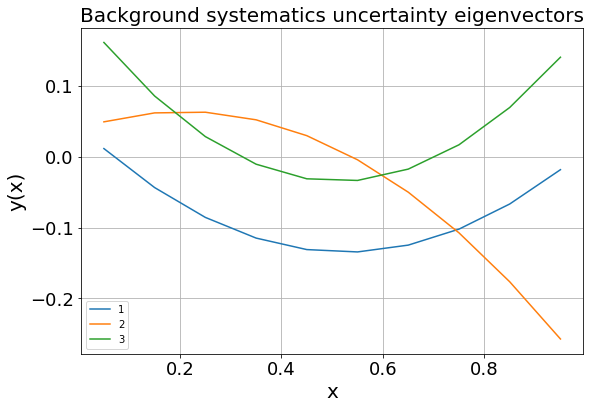

In [21]:
plt.figure(figsize=(9, 6))

for iv in range(nEV):
    plt.plot(xvec,muEVec[:,iv],'-',label=str(iv+1))

plt.title('Background systematics uncertainty eigenvectors',size=20)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')
plt.legend()
fname = '10_bg_fit_ev2_'+str(nEV)+'.png'
plt.savefig(fname)

In [32]:
# Check uncertainties resulting from eigenvectors

muErrEV = np.zeros(muvec.size)
muCovEV = np.zeros((muvec.size,muvec.size))

Nuse = 3   # Number of eigenvectors to use

if Nuse > nEV :
    Nuse = nEV

for iv in range(Nuse):
    muErrEV = muErrEV + muEVec[:,iv]*muEVec[:,iv]
    
muErrEV = np.sqrt(muErrEV)

# Covariance matrix

for ix in range(muvec.size):
    for jx in range(muvec.size):
        for iv in range(Nuse):
            muCovEV[ix,jx] = muCovEV[ix,jx] + muEVec[ix,iv]*muEVec[jx,iv]
                
# Printout

print("\n Fitted background:\n\n     x        mu_bg      sigma_bg    sigma_EV\n")

for ix in range(xvec.size):
    print("  %8.3f %8.3f  +/- %6.3f      %6.3f" % (xvec[ix],muvec[ix],muErr[ix],muErrEV[ix]))


muCorrEV = np.array(muCovEV)

print("\n Correlation matrix from ",Nuse," eigenvectors\n")

for ix in range(xvec.size):
    for jx in range(xvec.size):
        muCorrEV[ix,jx]=muCorrEV[ix,jx]/muErrEV[ix]/muErrEV[jx]

    print(muCorrEV[ix,:])

# For comparison

print("\n Correlation matrix from the fit \n")
for ix in range(xvec.size):
    print(muCorr[ix,:])


 Fitted background:

     x        mu_bg      sigma_bg    sigma_EV

     0.050   10.032  +/-  0.169       0.169
     0.150    9.771  +/-  0.114       0.114
     0.250    9.542  +/-  0.110       0.110
     0.350    9.344  +/-  0.127       0.127
     0.450    9.178  +/-  0.138       0.138
     0.550    9.042  +/-  0.139       0.139
     0.650    8.938  +/-  0.136       0.136
     0.750    8.864  +/-  0.149       0.149
     0.850    8.822  +/-  0.201       0.201
     0.950    8.812  +/-  0.294       0.294

 Correlation matrix from  3  eigenvectors

[ 1.000  0.847  0.360 -0.021 -0.217 -0.306 -0.293 -0.149  0.051  0.197]
[ 0.847  1.000  0.800  0.506  0.309  0.172  0.054 -0.044 -0.090 -0.092]
[ 0.360  0.800  1.000  0.921  0.805  0.675  0.473  0.152 -0.153 -0.328]
[-0.021  0.506  0.921  1.000  0.970  0.887  0.694  0.316 -0.089 -0.344]
[-0.217  0.309  0.805  0.970  1.000  0.969  0.824  0.470  0.048 -0.237]
[-0.306  0.172  0.675  0.887  0.969  1.000  0.935  0.660  0.266 -0.028]
[-0.293  0.054 

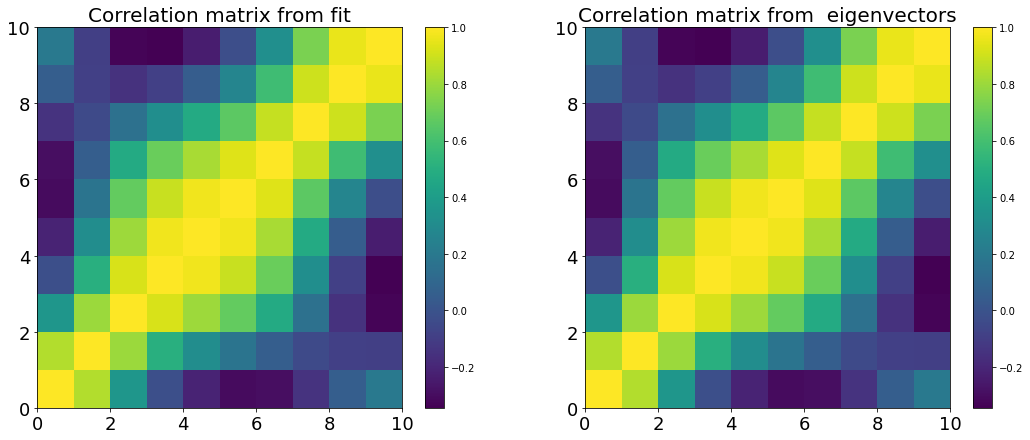

In [33]:
plt.subplots(1,2,figsize=(18, 7))

plt.subplot(121)
plt.pcolormesh(muCorr, cmap='viridis')
plt.colorbar()

plt.title('Correlation matrix from fit',size=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


plt.subplot(122)
plt.pcolormesh(muCorrEV, cmap='viridis')
plt.colorbar()

plt.title('Correlation matrix from  eigenvectors',size=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

fname = '10_bg_fit_ev3_'+str(nEV)+'.png'
plt.savefig(fname)